In [1]:
!pip install pillow

     |████████████████████████████████| 3.1 MB 29.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# Hardware used to run this notebook and tune all models:

All code was run using an NVIDIA Quadro P6000 GPU with 30 GB ram, which includes 8 CPUs. 

# <font color='red'> Instructions for Running Code </font>

This notebook will run the test set evaluation for ResNet44 and the ParaNet models. Simply run all cells in a linear fashion to replicate the evaluation process.

In [ ]:
!pip install seaborn

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Conv2D, BatchNormalization, add,
    Activation, AveragePooling2D, 
    MaxPooling2D, Input, Flatten, ZeroPadding2D
)
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os
import warnings
import time

# 1. Creating Directories to save results

In [2]:
cwd = os.getcwd()
testModel_dir = os.path.join(cwd,"testModels")
if not os.path.exists(testModel_dir):
    os.mkdir(testModel_dir)

# 2. Loading and Pre-processing the Data

This section is explained in more detail in Notebook1.ipynb, here we repeat the pre-processing steps on the full training set of 50,000 images (no validation set), in preparation for evaluating on the test set. 

In [3]:
# Load the CIFAR100 data.
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

169017344/169001437 [==============================] - 5s 0us/step


In [4]:
print("Training data has {} images with pixels of {}x{} and {} colour channels.".format(x_train.shape[0], 
                                                                                        x_train.shape[1],
                                                                                        x_train.shape[2],
                                                                                        x_train.shape[3]))
print("Test data has shape: {}".format(x_test.shape))
print("Labels have shape: {}".format(y_train.shape))

Training data has 50000 images with pixels of 32x32 and 3 colour channels.
Test data has shape: (10000, 32, 32, 3)
Labels have shape: (50000, 1)


## 2.1 Applying augmentations to the training set, and standardisation to test set

In [5]:
def make_numpy(img):
    img = np.array(img)
    return img.astype('float32')

augment_and_normalise = ImageDataGenerator(
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # randomly flip images
    horizontal_flip=True,
    # randomly rotate images
    rotation_range = 20,
    # randomly darken and lighten some images
    brightness_range = [0.5, 1.1],
    # apply featurewise centering (mean of RGB subtracted channel wise)
    featurewise_center=True,
    # standardise by RGB values
    featurewise_std_normalization = True,
    # scale from 0-255 to 0-1., applied after all other transforms
    rescale = 1./255,
    preprocessing_function=make_numpy
)

# We need to fit to the training data before applying standardisations to the test data
augment_and_normalise.fit(x_train)
x_test = augment_and_normalise.standardize(x_test)

In [6]:
# convert labels to one hot encoing 
num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# 3. Defining Models

Each of these models was detailed in Notebook1, here we define them again for evaluation. 

## 3.1 ResNet44

In [7]:
def make_conv(inputs, filters, stride, ks = 3, bnorm=True, activation='relu'):
    """
    Creates a convolutional neural network block. 
    """
    x = Conv2D(filters=filters, kernel_size=ks, strides=stride, padding='same', 
                  kernel_initializer='he_normal', # as specified in the linked paper
                  kernel_regularizer=l2(1e-4))(inputs)
    
    if bnorm:
        x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x)
        
    return x   

def ResNet_Cifar(n):
    """
    Based on the original ResNet paper where they explain an implementation for Cifar10. 
    Here we recreate this implementation with the hope of using it for Cifar100. 
    
    They specify a formula to create different network depths, e.g. they offer n = 3,5,7,9 as possible
    values to try with a formula where total layers = 6*n + 2 
    (1 layer for first convolution on input, 1 layer for output) 
    """
    # specify the shape of first layer for Cifar Images
    inputs = Input(shape=(32,32,3))
    
    # initialise the number of filters, kernel size, and stride
    filters = 16
    ks = 3
    stride = 1
    
    # first convolution layer
    x = Conv2D(filters=filters, kernel_size=ks, strides=1, padding='same', 
                  kernel_initializer='he_normal', # as specified in the linked paper
                  kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # create the set of three
    for stack in range(3):
        # create n blocks of 3 layers per stack
        for block in range(n):
            # default stride is 1
            stride = 1
            # downsample by half when we hit a new block (except for first block)
            if stack > 0 and block == 0:
                stride = 2
            # two conv blocks
            y = make_conv(inputs=x, filters=filters, stride=stride)
            y = make_conv(inputs=y, filters=filters, stride=1,activation=None)
            # first layer but not first stack
            if stack > 0 and block == 0:  
                # need to downsample the identity transfer to match changed dims 
                # when changing blocks
                x = make_conv(inputs=x, filters=filters, ks=1, stride=stride,
                                 activation=None, bnorm=False)
            # make the residual connection within each block
            x = add([x, y])
            x = Activation('relu')(x)
        filters *= 2
        
    # Add classification layer
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(100, activation='softmax', kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

## 3.2 ParaNet (our novel architecture)

In [8]:
def downSample(inputs, filters, repeats, name):
    """
    Downsamples the image/map dimensions by half by a linear projection through a convolution layer with stride 2. 
    """
    x = inputs
    for i in range(repeats):
        x = Conv2D(filters=filters, kernel_size=1, strides=2, padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  name = name+'rep'+str(i))(x)
    return x

def makeChannel(inputs, filters, layers, name):
    """
    Creates an individual convolution channel through which the image is passed without downsampling. 
    """
    x = inputs
    for l in range(layers):
        x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  name = name+str(l)+'Conv')(x)
        x = BatchNormalization(name = name+str(l)+'BN')(x)
        x = Activation('relu', name = name+str(l)+'Relu')(x)
    return x

def ParaNet(channel_layers):
    """
    Function to instantiate a ParaNet model. 
    
    channel_layers specifies the number of convolution layers to include in each channel. 
    """
    # specify the shape of first layer for Cifar Images
    inputs = Input(shape=(32,32,3))
    
    # first convolution layer is a 3 x 3 kernel of stride 1 with 16 filters
    x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # split into three channels
    x_left = downSample(x, filters = 64, repeats = 2, name='LeftDown1')    # will be downsampled to an 8 x 8 map with 64 filters
    x_right = downSample(x, filters = 32, repeats = 1, name='RightDown1')   # will be downsampled to a 16 x 16 map with 32 filters
    x_center = x  # will remain as a 32 x 32 map with 16 filters
    
    # create each channel
    x_left_out = makeChannel(x_left, filters = 64, layers = channel_layers, name='LeftChannel')
    x_right_out = makeChannel(x_right, filters = 32, layers = channel_layers, name='RightChannel') # these were at 64 filters
    x_center_out = makeChannel(x_center, filters = 16, layers = channel_layers, name='CenterChannel') # these were at 64 filters
    
    # downsample to match smallest map size
    x_right_end = downSample(x_right_out, filters = 64, repeats = 1, name='RightDown2')
    x_center_end = downSample(x_center_out, filters = 64, repeats = 2, name='CenterDown')
    x_left_end = x_left_out
    
    # downsample original input to create a residual connection
    x = downSample(x, filters = 64, repeats = 2, name = 'residual')
    
    # combine the final layers
    output = add([x, x_right_end, x_center_end, x_left_end])
    output = Activation('relu')(output)
        
    # Add classification layer
    output = AveragePooling2D(pool_size=8)(output)
    output = Flatten()(output)
    outputs = Dense(100, activation='softmax', kernel_initializer='he_normal')(output)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 4. Model Parameters

Based on the results from Notebook1, we will try three models here: ResNet44 with the learning rate schedule as specified in the original ResNet paper (as a baseline), ResNet44 with the 1Cycle Policy, and ParaNet10 with the 1Cycle policy. 

## 4.1 Loss Function

All models were tested with a common loss function: Categorical CrossEntropy with Label Smoothing value of 0.1

In [9]:
loss = CategoricalCrossentropy(label_smoothing=0.1)

## 4.2 ResNet44 Parameters

### 4.2.1 Learning Rate

In [10]:
def learning_rate_schedule(epoch):
    """
    Based on the paper, learning rate is reduced after 80, 120, 160, 180 epochs.
    Used as a training callback (called after every epoch). 
    
    epoch INTEGER -> learningRate FLOAT
    """
    learningRate = 1e-3
    if epoch > 180:
        learningRate *= 0.5e-3
    elif epoch > 160:
        learningRate *= 1e-3
    elif epoch > 120: 
        learningRate *= 1e-2
    elif epoch > 80:
        learningRate *= 1e-1
    return learningRate

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

## 4.3 ResNet44, ParaNet10 1Cycle

Here we redefine the 1Cycle policy introduced in Notebook 1. We drew inspiration from the FastAI source code when writing this function, see their code here: https://github.com/fastai/fastai1/blob/master/fastai/callbacks/one_cycle.py#L8

In [11]:
class cosineAnneal:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.step_num = 0
        
    def step(self):
        self.step_num += 1
        cos = np.cos(np.pi * (self.step_num / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos

class OneCycle(Callback):
    """
    A ported replica of the implementation of the one cycle policy from the FastAi library.
    This callback is not available in Keras, thus it was re-implemented here. 
    """
    def __init__(self, max_lr, steps, momentum_range, first_phase = 0.3, factor = 25):
        super(OneCycle, self).__init__()
        min_lr = max_lr / factor # set the minimum learning rate
        end_lr = max_lr / (factor * 1e4)
        # get min and max momentum
        m_min, m_max = momentum_range[0], momentum_range[1]
        
        # calculate number of steps for initial warm up
        first_phase_steps = first_phase * steps
        # calculate number of steps for drop off
        second_phase_steps = (1-first_phase) * steps
        self.steps1 = first_phase_steps
        self.steps2 = second_phase_steps
        # initialise which phase and step
        self.phase = 0
        self.step = 0
        
        self.phases = [[cosineAnneal(min_lr, max_lr, self.steps1), cosineAnneal(m_max, m_min, self.steps1)], 
                 [cosineAnneal(max_lr, end_lr, self.steps2), cosineAnneal(m_min, m_max, self.steps2)]]
        
        self.lrs = []
        self.moms = []
        
    def reset(self):
        self.phase = 0
        self.step = 0
        
    def on_train_begin(self, logs=None):
        self.reset()
        # set initial learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr_sched().start)
        # set initial momentum
        tf.keras.backend.set_value(self.model.optimizer.momentum, self.mom_sched().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.moms.append(tf.keras.backend.get_value(self.model.optimizer.momentum))

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.steps1:
            self.phase = 1
            
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr_sched().step())
        tf.keras.backend.set_value(self.model.optimizer.momentum, self.mom_sched().step())
        
    def lr_sched(self):
        """
        returns the cosineAnneal class for this 
        """
        return self.phases[self.phase][0]
    
    def mom_sched(self):
        """
        Gets the list of momentums generated by the cosine curve. 
        """
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')
        
def calc_steps(x, epochs, bs):
    """
    Calculates the number of steps based on training samples, batch size (bs),
    and the number of epochs desired.
    """
    return np.ceil(len(x)/bs) * epochs

# 5. Fitting on the full training set

In contrast to Notebook1 which fit these models on a 45000 image training set and 5000 image validation set, here we fit each model to the full 50,000 image training set, before evaluating on the 10,000 image test set. 

In [12]:
# initialise GPUs
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2021-11-03 02:09:18.147333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 02:09:18.339928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 02:09:18.341777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 5.1 ResNet44 Fit

In [13]:
r44 = ResNet_Cifar(n=7)

r44.compile(loss=loss,
              optimizer=Adam(learning_rate=learning_rate_schedule(0)),
              metrics=['accuracy'])

r44_start = time.time()
# Fit the model on the batches generated by datagen.flow().
callbacks = [lr_reducer, lr_scheduler]
r44_history = r44.fit(augment_and_normalise.flow(x_train, y_train, 
                                                      batch_size=128),
                           epochs=200, verbose=1,
                           callbacks=callbacks)
r44_end = time.time()

2021-11-03 02:09:21.984614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 02:09:21.986544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 02:09:21.988191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 02:09:25.497710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 02:09:25.499027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Epoch 1/200


2021-11-03 02:09:34.089601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


391/391 [==============================] - 51s 100ms/step - loss: 4.5811 - accuracy: 0.0887 24s - loss: 4.9839 - accuracy:  - ETA: 23s - loss: 4.9657 - accuracy: 0 - ETA: 23s - los - ETA
Epoch 2/200
391/391 [==============================] - 39s 100ms/step - loss: 4.0001 - accuracy: 0.1782
Epoch 3/200
391/391 [==============================] - 39s 101ms/step - loss: 3.7220 - accuracy: 0.2346
Epoch 4/200
391/391 [==============================] - 40s 102ms/step - loss: 3.5023 - accuracy: 0.2873
Epoch 5/200
391/391 [==============================] - 39s 100ms/step - loss: 3.3321 - accuracy: 0.3279
Epoch 6/200
391/391 [==============================] - 40s 101ms/step - loss: 3.1844 - accuracy: 0.3636
Epoch 7/200
391/391 [==============================] - 40s 101ms/step - loss: 3.0618 - accuracy: 0.3955
Epoch 8/200
391/391 [==============================] - 39s 101ms/step - loss: 2.9617 - accuracy: 0.4253s
Epoch 9/200
391/391 [==============================] - 39s 101ms/step - loss: 2.8809

Epoch 34/200
391/391 [==============================] - 40s 101ms/step - loss: 2.1950 - accuracy: 0.6592
Epoch 35/200
391/391 [==============================] - 40s 101ms/step - loss: 2.1861 - accuracy: 0.6596
Epoch 36/200
391/391 [==============================] - 40s 101ms/step - loss: 2.1757 - accuracy: 0.6637
Epoch 37/200
391/391 [==============================] - 39s 100ms/step - loss: 2.1714 - accuracy: 0.6637
Epoch 38/200
391/391 [==============================] - 39s 101ms/step - loss: 2.1660 - accuracy: 0.6677
Epoch 39/200
391/391 [==============================] - 40s 101ms/step - loss: 2.1507 - accuracy: 0.6719
Epoch 40/200
391/391 [==============================] - 40s 101ms/step - loss: 2.1467 - accuracy: 0.6739
Epoch 41/200
391/391 [==============================] - 40s 101ms/step - loss: 2.1363 - accuracy: 0.6749
Epoch 42/200
391/391 [==============================] - 40s 101ms/step - loss: 2.1374 - accuracy: 0.6789
Epoch 43/200
391/391 [==============================] -

Epoch 67/200
391/391 [==============================] - 40s 102ms/step - loss: 2.0096 - accuracy: 0.7215
Epoch 68/200
391/391 [==============================] - 40s 102ms/step - loss: 2.0086 - accuracy: 0.7242
Epoch 69/200
391/391 [==============================] - 39s 100ms/step - loss: 2.0050 - accuracy: 0.7222
Epoch 70/200
391/391 [==============================] - 40s 101ms/step - loss: 1.9993 - accuracy: 0.7269
Epoch 71/200
391/391 [==============================] - 40s 101ms/step - loss: 1.9939 - accuracy: 0.7282
Epoch 72/200
391/391 [==============================] - 40s 101ms/step - loss: 1.9946 - accuracy: 0.7283
Epoch 73/200
391/391 [==============================] - 40s 101ms/step - loss: 1.9893 - accuracy: 0.7296
Epoch 74/200
391/391 [==============================] - 39s 100ms/step - loss: 1.9851 - accuracy: 0.7293
Epoch 75/200
391/391 [==============================] - 40s 101ms/step - loss: 1.9873 - accuracy: 0.7322
Epoch 76/200
391/391 [==============================] -

Epoch 100/200
391/391 [==============================] - 40s 101ms/step - loss: 1.5900 - accuracy: 0.8637s - loss: 1.5899 - accuracy - ETA: 0s - loss: 1.5900 - accuracy: 0.86
Epoch 101/200
391/391 [==============================] - 40s 101ms/step - loss: 1.5851 - accuracy: 0.8640
Epoch 102/200
391/391 [==============================] - 40s 101ms/step - loss: 1.5809 - accuracy: 0.8649
Epoch 103/200
391/391 [==============================] - 40s 102ms/step - loss: 1.5725 - accuracy: 0.8685
Epoch 104/200
391/391 [==============================] - 40s 101ms/step - loss: 1.5686 - accuracy: 0.8691
Epoch 105/200
391/391 [==============================] - 40s 101ms/step - loss: 1.5664 - accuracy: 0.8684
Epoch 106/200
391/391 [==============================] - 40s 101ms/step - loss: 1.5614 - accuracy: 0.8716
Epoch 107/200
391/391 [==============================] - 39s 100ms/step - loss: 1.5569 - accuracy: 0.8735
Epoch 108/200
391/391 [==============================] - 39s 100ms/step - loss: 1.5

Epoch 133/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4703 - accuracy: 0.8979
Epoch 134/200
391/391 [==============================] - 40s 102ms/step - loss: 1.4684 - accuracy: 0.8975
Epoch 135/200
391/391 [==============================] - 39s 100ms/step - loss: 1.4672 - accuracy: 0.8992s - los
Epoch 136/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4630 - accuracy: 0.9011
Epoch 137/200
391/391 [==============================] - 39s 101ms/step - loss: 1.4677 - accuracy: 0.8983
Epoch 138/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4665 - accuracy: 0.8986
Epoch 139/200
391/391 [==============================] - 39s 101ms/step - loss: 1.4685 - accuracy: 0.8974
Epoch 140/200
391/391 [==============================] - 39s 100ms/step - loss: 1.4648 - accuracy: 0.9001
Epoch 141/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4669 - accuracy: 0.8998
Epoch 142/200
391/391 [================

Epoch 166/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4524 - accuracy: 0.9012
Epoch 167/200
391/391 [==============================] - 39s 101ms/step - loss: 1.4501 - accuracy: 0.9037
Epoch 168/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4488 - accuracy: 0.9043
Epoch 169/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4512 - accuracy: 0.9054
Epoch 170/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4510 - accuracy: 0.9048
Epoch 171/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4475 - accuracy: 0.9057
Epoch 172/200
391/391 [==============================] - 39s 100ms/step - loss: 1.4532 - accuracy: 0.9013
Epoch 173/200
391/391 [==============================] - 40s 102ms/step - loss: 1.4523 - accuracy: 0.9036
Epoch 174/200
391/391 [==============================] - 40s 101ms/step - loss: 1.4508 - accuracy: 0.9037
Epoch 175/200
391/391 [=======================

Epoch 199/200
391/391 [==============================] - 40s 102ms/step - loss: 1.4486 - accuracy: 0.9047
Epoch 200/200
391/391 [==============================] - 39s 100ms/step - loss: 1.4510 - accuracy: 0.9037


In [14]:
print(f"Fit time for ResNet44 with paper learning schedule: {(r44_end-r44_start)/60} minutes")

Fit time for ResNet44 with paper learning schedule: 132.68726294438045 minutes


In [15]:
r44_savepath = os.path.join(testModel_dir, "ResNet44-PaperLR-200epochs.h5")
r44.save(r44_savepath, save_format='h5')

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 5.2 ResNet44 1Cycle Fit

In [16]:
# parameters
batch_size = 128
num_samples = x_train.shape[0]
num_epoch = 100 
max_lr = 3e-3

# defining one cycle policy learning
lr_policy = OneCycle(steps=calc_steps(x_train, epochs = num_epoch, bs=batch_size),
                    max_lr = max_lr,
                    momentum_range=[0.85, 0.95])

# defining model
r44_1Cycle = ResNet_Cifar(n=7)

# compiling the model
r44_1Cycle.compile(loss = loss, optimizer=tf.keras.optimizers.RMSprop(max_lr), metrics=['accuracy'])

r44_1CycleStart = time.time()
# fitting the model                    
r44_1Cycle_history = r44_1Cycle.fit(augment_and_normalise.flow(x_train, y_train, 
                                                                   batch_size=batch_size),
                                        epochs=num_epoch,
                                        callbacks=[lr_policy])
r44_1CycleEnd = time.time()

Epoch 1/100
391/391 [==============================] - 50s 102ms/step - loss: 5.4377 - accuracy: 0.0224
Epoch 2/100
391/391 [==============================] - 40s 102ms/step - loss: 4.5830 - accuracy: 0.0712
Epoch 3/100
391/391 [==============================] - 40s 103ms/step - loss: 4.3359 - accuracy: 0.1138
Epoch 4/100
391/391 [==============================] - 40s 103ms/step - loss: 4.1575 - accuracy: 0.1493
Epoch 5/100
391/391 [==============================] - 40s 103ms/step - loss: 4.0148 - accuracy: 0.1764
Epoch 6/100
391/391 [==============================] - 40s 102ms/step - loss: 3.8886 - accuracy: 0.2015
Epoch 7/100
391/391 [==============================] - 40s 102ms/step - loss: 3.7653 - accuracy: 0.2280
Epoch 8/100
391/391 [==============================] - 40s 103ms/step - loss: 3.6642 - accuracy: 0.2498
Epoch 9/100
391/391 [==============================] - 40s 103ms/step - loss: 3.5553 - accuracy: 0.2745
Epoch 10/100
391/391 [==============================] - 40s 102m

In [17]:
print(f"Fit time for ResNet44 with 1Cycle Policy for 100 Epochs: {(r44_1CycleEnd-r44_1CycleStart)/60} minutes")

Fit time for ResNet44 with 1Cycle Policy for 100 Epochs: 67.43576990365982 minutes


In [18]:
r44_1Cycle_savepath = os.path.join(testModel_dir, "ResNet44-1Cycle-100epochs.h5")
r44_1Cycle.save(r44_1Cycle_savepath, save_format='h5')

## 5.3 ParaNet10 1Cycle Fit

In [19]:
# parameters
batch_size = 128
num_samples = x_train.shape[0]
num_epoch = 100 
max_lr = 3e-3

# defining one cycle policy learning
lr_policy = OneCycle(steps=calc_steps(x_train, epochs = num_epoch, bs=batch_size),
                    max_lr = max_lr,
                    momentum_range=[0.85, 0.95])

# defining model
paraNet10Model = ParaNet(channel_layers = 10)

# defining loss 
loss = CategoricalCrossentropy(label_smoothing = 0.1)

# compiling the model
paraNet10Model.compile(loss = loss, optimizer=tf.keras.optimizers.RMSprop(max_lr), metrics=['accuracy'])

p10_1CycleStart = time.time()
# fitting the model                    
history = paraNet10Model.fit(augment_and_normalise.flow(x_train, y_train, 
                                                        batch_size=128),                        
                             epochs=num_epoch,
                             callbacks=[lr_policy])

p10_1CycleEnd = time.time()

Epoch 1/100
391/391 [==============================] - 47s 102ms/step - loss: 4.9411 - accuracy: 0.0375
Epoch 2/100
391/391 [==============================] - 40s 103ms/step - loss: 4.5358 - accuracy: 0.0888
Epoch 3/100
391/391 [==============================] - 40s 103ms/step - loss: 4.3508 - accuracy: 0.1185
Epoch 4/100
391/391 [==============================] - 40s 103ms/step - loss: 4.2035 - accuracy: 0.1447
Epoch 5/100
391/391 [==============================] - 40s 103ms/step - loss: 4.0749 - accuracy: 0.1679
Epoch 6/100
391/391 [==============================] - 40s 103ms/step - loss: 3.9630 - accuracy: 0.1900
Epoch 7/100
391/391 [==============================] - 40s 102ms/step - loss: 3.8519 - accuracy: 0.2121
Epoch 8/100
391/391 [==============================] - 41s 104ms/step - loss: 3.7584 - accuracy: 0.2264
Epoch 9/100
391/391 [==============================] - 40s 102ms/step - loss: 3.6627 - accuracy: 0.2477
Epoch 10/100
391/391 [==============================] - 40s 102m

In [20]:
print(f"Fit time for ParaNet10 with 1Cycle Policy for 100 Epochs: {(p10_1CycleEnd-p10_1CycleStart)/60} minutes")

Fit time for ParaNet10 with 1Cycle Policy for 100 Epochs: 67.24485469261805 minutes


In [21]:
paraNet10Model_savepath = os.path.join(testModel_dir, "paraNet10-1Cycle-100epochs.h5")
paraNet10Model.save(paraNet10Model_savepath, save_format='h5')

# 6. Evaluating on the test set

In [22]:
# ResNet44 predictions with paper learning rate
r44_predictions = r44.predict(x_test)
# ResNet44 predictions with 1Cycle learning rat
r44_1Cycle_predictions = r44_1Cycle.predict(x_test)
# ParaNet10 predictions with 1Cycle learning rate
paraNet10Model_predictions = paraNet10Model.predict(x_test)

## 6.1 Generate Classification Reports

In [39]:
# ResNet44 Classification Report
r44_matrix = classification_report(y_test.argmax(axis=1), r44_predictions.argmax(axis=1), digits=4)
print(r44_matrix)

              precision    recall  f1-score   support

           0     0.9231    0.8400    0.8796       100
           1     0.8515    0.8600    0.8557       100
           2     0.5631    0.5800    0.5714       100
           3     0.7018    0.4000    0.5096       100
           4     0.5581    0.4800    0.5161       100
           5     0.6903    0.7800    0.7324       100
           6     0.8049    0.6600    0.7253       100
           7     0.6837    0.6700    0.6768       100
           8     0.5828    0.8800    0.7012       100
           9     0.8387    0.7800    0.8083       100
          10     0.5116    0.4400    0.4731       100
          11     0.5152    0.5100    0.5126       100
          12     0.5846    0.7600    0.6609       100
          13     0.6923    0.6300    0.6597       100
          14     0.5315    0.7600    0.6255       100
          15     0.7340    0.6900    0.7113       100
          16     0.7143    0.7500    0.7317       100
          17     0.7685    

In [40]:
# ResNet44 1Cycle Classification Report
r44_1Cycle_matrix = classification_report(y_test.argmax(axis=1), r44_1Cycle_predictions.argmax(axis=1), digits=4)
print(r44_1Cycle_matrix)

              precision    recall  f1-score   support

           0     0.8913    0.8200    0.8542       100
           1     0.8667    0.7800    0.8211       100
           2     0.6238    0.6300    0.6269       100
           3     0.6721    0.4100    0.5093       100
           4     0.4828    0.4200    0.4492       100
           5     0.6909    0.7600    0.7238       100
           6     0.7340    0.6900    0.7113       100
           7     0.7303    0.6500    0.6878       100
           8     0.6742    0.8900    0.7672       100
           9     0.8351    0.8100    0.8223       100
          10     0.5526    0.4200    0.4773       100
          11     0.5354    0.5300    0.5327       100
          12     0.6119    0.8200    0.7009       100
          13     0.6941    0.5900    0.6378       100
          14     0.4901    0.7400    0.5896       100
          15     0.7340    0.6900    0.7113       100
          16     0.6179    0.7600    0.6816       100
          17     0.8020    

In [41]:
# ParaNet10 Classification Report
paraNet10_matrix = classification_report(y_test.argmax(axis=1), paraNet10Model_predictions.argmax(axis=1), digits=4)
print(paraNet10_matrix)

              precision    recall  f1-score   support

           0     0.8901    0.8100    0.8482       100
           1     0.8068    0.7100    0.7553       100
           2     0.4808    0.5000    0.4902       100
           3     0.6757    0.2500    0.3650       100
           4     0.3750    0.3300    0.3511       100
           5     0.5900    0.5900    0.5900       100
           6     0.7000    0.6300    0.6632       100
           7     0.6600    0.6600    0.6600       100
           8     0.4422    0.8800    0.5886       100
           9     0.8696    0.6000    0.7101       100
          10     0.5890    0.4300    0.4971       100
          11     0.5181    0.4300    0.4699       100
          12     0.5714    0.7200    0.6372       100
          13     0.6383    0.6000    0.6186       100
          14     0.4048    0.6800    0.5075       100
          15     0.6044    0.5500    0.5759       100
          16     0.5804    0.6500    0.6132       100
          17     0.7545    

## 6.2 Generating Confusion Matrices

In [57]:
def plot_conf_matrix(true, pred, title):
    figure = plt.figure(figsize=(15, 15))
    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix(true, pred), annot=False,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    

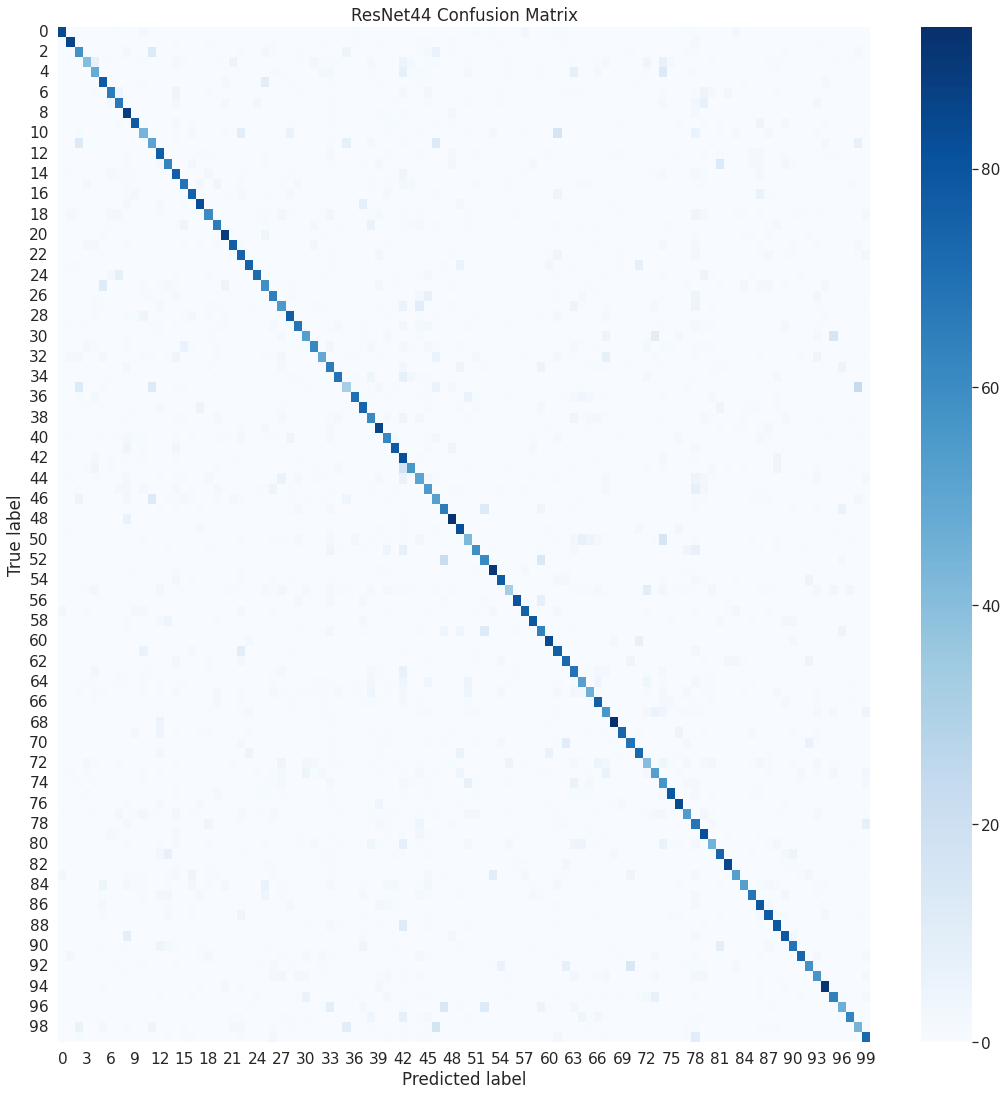

In [58]:
plot_conf_matrix(y_test.argmax(axis=1), 
                 r44_predictions.argmax(axis=1),
                'ResNet44 Confusion Matrix')

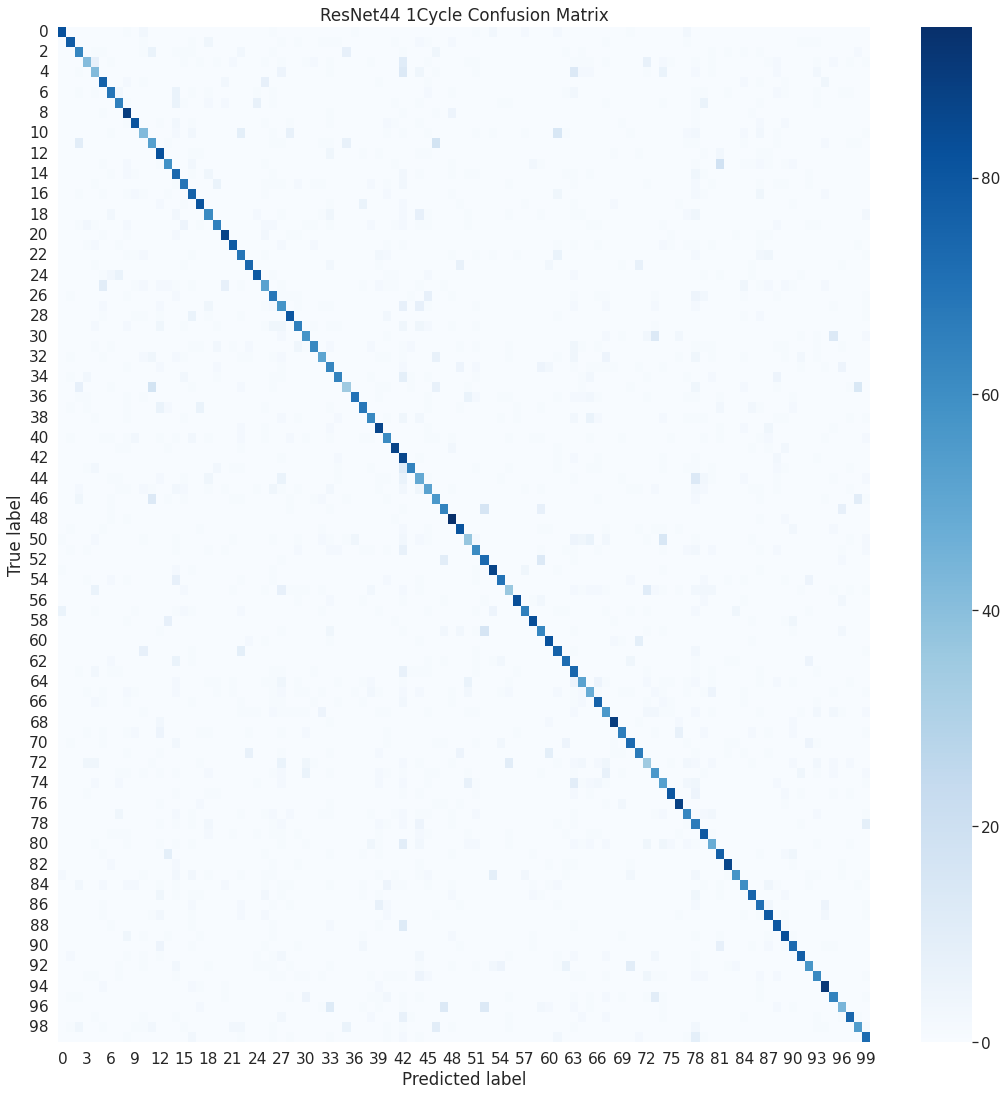

In [59]:
plot_conf_matrix(y_test.argmax(axis=1), 
                 r44_1Cycle_predictions.argmax(axis=1),
                'ResNet44 1Cycle Confusion Matrix')

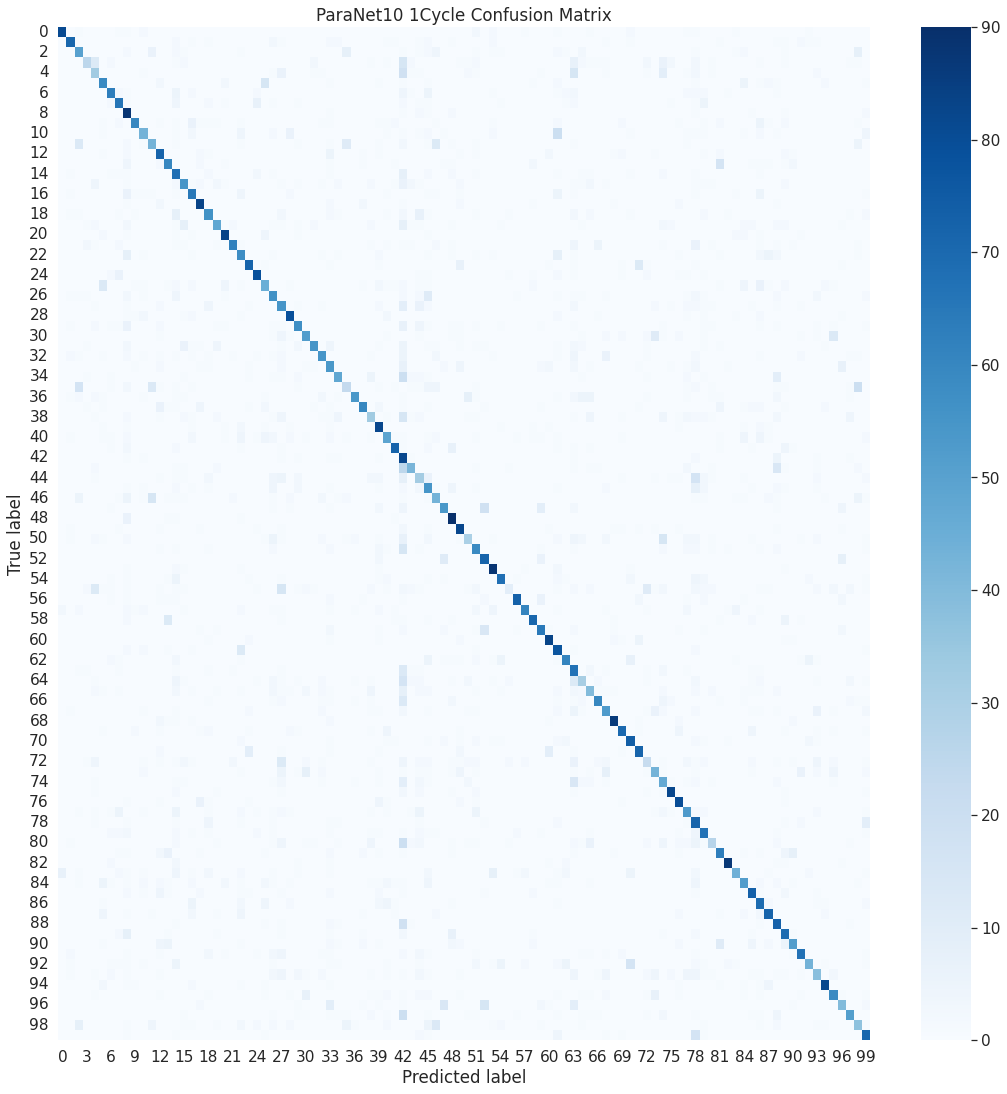

In [61]:
plot_conf_matrix(y_test.argmax(axis=1), 
                 paraNet10Model_predictions.argmax(axis=1),
                'ParaNet10 1Cycle Confusion Matrix')